# NEST by Example: An Introduction to the Neural Simulation Tool NEST

### Marc-Oliver Gewaltig, Abigail Morrison, Hans Ekkehard Plesser

#### This notebook adapted to NEST 3.3 was created by Hans Ekkehard Plesser
#### Revised for NEST 3.6 by Nicolai Haug and Hans Ekkehard Plesser

## Introduction

NEST (NEural Simulation Tool) is an open-source software designed for the simulation of large-scale spiking neural network models. NEST is optimized for simulation of networks of point neurons, that is, neuron models that collapse the morphology and biophysical complexity of nerve cells into a single compartment. This simplification makes NEST particurarly useful for questions about the dynamics, size and structure of large neuronal networks with complex connectivity.

Though the NEST simulation kernel is written in highly optimized C++ to obtain the best possible performance for the simulation, NEST offers a convenient Python interface for writing simulation scripts. In this tutorial, we give an introduction to NEST's Python interface.

## Basic Terminology

* **Nodes** are all neurons, devices, and also sub-networks. Nodes have a dynamic state that changes over time and that can be influenced by incoming events. In NEST, we can distinguish roughly between three types of nodes
    * **Stimulation devices** such as `poisson_generator`, `spike_generator` or `noise_generator`.  These devices only produce output (spikes or currents) that is sent to other nodes, but do not receive any input. 
    * **Recording devices**, such as `spike_recorder`, `voltmeter` or `multimeter`. These devices collect data from other nodes and store it in memory or in files for analysis. They only receive input, but do not emit any output events to other nodes.
    * **Neurons**, such as `iaf_psc_alpha` represent our model neurons in the network. They can receive spike and current input and emit spike output.
* **Events** are pieces of information of a particular type. The most common event is the spike-event. Other event types are voltage events and current events.
* **Connections** are communication channels between nodes. Only if one node is connected to another node, can they exchange events. Connections are weighted, directed, and specific to one event type. 
    * **Source**: The node that sending an event (spike)
    * **Target**: The node that receiving an event (spike)
    * **Weight**: How strongly will an event will influence the target node?
    * **Delay**: How long does the event take from source to target?

## NEST Desktop

- Interactive, graphical frontend for NEST
- Developed by Sebastian Spreizer, U Freiburg/FZ Jülich/U Trier, currently funded by Human Brain Project
- Documentation: https://nest-desktop.readthedocs.io/en/latest/
- Run online: https://nest-desktop.apps.hbp.eu (requires HBP account)

## Notebook preparations

We first import some packages that we will need for data analysis and plotting ([NumPy](http://www.numpy.org), [Pandas](http://pandas.pydata.org), [Matplotlib](http://matplotlib.org)) and instruct the notebook to render all figures inside the notebook. We also increase the figures size, as the default figure size is rather small for most modern displays.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = (14, 4)

## Firing up NEST

1. Try `import nest` first. If that works, proceed to **Getting Help**.
1. If that fails, complaining that it cannot find module `nest`, you need to extend you Python path to include the installation location of the NEST Python module on your computer.
1. The easiest way to do so is to run

        source <path to nest>/install/bin/nest_vars.sh
   
   **before** starting Python or Jupyter notebook.

In [3]:
import nest


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Nov  6 2023 15:05:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Getting Help

NEST provides several levels of online documentation

#### The NEST Helpdesk

NEST has [comprehensive online documentation](https://nest-simulator.readthedocs.io).

#### Help on the NEST Python interface

To obtain help on the NEST Python interface, you can either use the Python `help()` function or the IPython help mechanism by placing a `?` behind a command name, e.g.,

In [4]:
nest.Create?

Signature: nest.Create(model, n=1, params=None, positions=None)
Docstring:
Create one or more nodes.

Generates `n` new network objects of the supplied model type. If `n` is not
given, a single node is created. Note that if setting parameters of the
nodes fail, the nodes will still have been created.

Note
----
During network construction, create all nodes representing model neurons first, then all nodes
representing devices (generators, recorders, or detectors), or all devices first and then all neurons.
Otherwise, network connection can be slow, especially in parallel simulations of networks
with many devices.

Parameters
----------
model : str
    Name of the model to create
n : int, optional
    Number of nodes to create
params : dict or list, optional
    Parameters for the new nodes. Can be any of the following:

    - A dictionary with either single values or lists of size n.
      The single values will be applied to all nodes, while the lists will be distributed across
      t

## A first example

In this example, we create a simple network consisting of the following elements:

* A single leaky integrate-and-fire neuron
* Sinusoidal current injection (`ac_generator`)
* Excitatory and inhibtory spike input (`poisson_generator`) via current-based synapses
* A `voltmeter` to record the voltage trace

#### Reset NEST to its original state

The `ResetKernel()` command resets the simulation kernel. This will destroy any previously created nodes and connections, and reset the internal clock to zero. The parameters of built-in models are also reset to their defaults. Calling this function is equivalent to restarting NEST.

In [5]:
nest.ResetKernel()

#### Set kernel attributes

The NEST kernel can be controlled from the Python interface by setting attributes, such as the simulation resolution, on the `nest` module:

In [6]:
nest.resolution = 0.1


Nov 06 15:10:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


#### Create network nodes

A neural network in NEST consists of two basic element types: nodes and connections. New nodes are created with the command `Create()`, which has the following call signature:

```Python
Create(model, n=1, params=None)
```

This will create `n` instances of type `model`. Parameters for the new nodes can be given as `params`, which can be any of the following:

* A dictionary with either single values or lists of size `n`. The single values will be applied to all nodes, while the lists will be distributed across the nodes. Both single values and lists can be given at the same time.
* A list with `n` dictionaries, one dictionary for each node.

If `params` is omitted from the function call, the model's default parameters are used.

In [7]:
neuron = nest.Create("iaf_psc_alpha")

sine = nest.Create(
    "ac_generator",
    params={
        "amplitude": 100.0,
        "frequency": 2.0
    }
)

noise = nest.Create(
    "poisson_generator",
    2,
    params=[
        {"rate": 70000.0},
        {"rate": 20000.0}
    ]
)

voltmeter = nest.Create(
    "voltmeter",
    params={
        "interval": 1.0
    }
)

#### Inspect created nodes

The `Create()` function returns a `NodeCollection`. A `NodeCollection` is a compact representation of the node handles, which are integer numbers, called node IDs. The node IDs are assigned in the order which nodes are created. The first node is assigned ID 1, the second node ID 2, and so on.

We can inspect a `NodeCollection` by printing the variable we assigned it to:

In [8]:
print(neuron)
print(sine)
print(noise)
print(voltmeter)

NodeCollection(metadata=None, model=iaf_psc_alpha, size=1, first=1)
NodeCollection(metadata=None, model=ac_generator, size=1, first=2)
NodeCollection(metadata=None, model=poisson_generator, size=2, first=3, last=4)
NodeCollection(metadata=None, model=voltmeter, size=1, first=5)


We can use `NodeCollection` to access the properties of nodes. Properties of nodes in NEST are generally accessed through Python dictionaries of key-value pairs of the form `{key: value}`. In order to see which properties a node has, we can use the `.get()` function to ask for its status:

In [9]:
neuron.get()

{'archiver_length': 0,
 'beta_Ca': 0.001,
 'C_m': 250.0,
 'Ca': 0.0,
 'E_L': -70.0,
 'element_type': 'neuron',
 'frozen': False,
 'global_id': 1,
 'I_e': 0.0,
 'local': True,
 'model': 'iaf_psc_alpha',
 'model_id': 46,
 'node_uses_wfr': False,
 'post_trace': 0.0,
 'recordables': ('I_syn_ex', 'I_syn_in', 'V_m'),
 'synaptic_elements': {},
 't_ref': 2.0,
 't_spike': -1.0,
 'tau_Ca': 10000.0,
 'tau_m': 10.0,
 'tau_minus': 20.0,
 'tau_minus_triplet': 110.0,
 'tau_syn_ex': 2.0,
 'tau_syn_in': 2.0,
 'thread': 0,
 'thread_local_id': -1,
 'V_m': -70.0,
 'V_min': -inf,
 'V_reset': -70.0,
 'V_th': -55.0,
 'vp': 0}

Many of these properties are not relevant for the dynamics of the neuron. To find out what the interesting properties are, look at the documentation of the model through the helpdesk. If you already know which properties you are interested in, you can specify a key, or a list of keys, as an optional argument to `.get()`:

In [10]:
print(neuron.get("I_e"))
print(neuron.get(["V_reset", "V_th"]))

0.0
{'V_reset': -70.0, 'V_th': -55.0}


To modify the properties in the dictionary, we can use `.set()`. The `.set()` function permits setting properties as keyword arguments:

In [11]:
neuron.set(V_reset=-65.0, V_th=-50.0)
neuron.get(["V_reset", "V_th"])

{'V_reset': -65.0, 'V_th': -50.0}

Properties can also be set by providing key-value pairs in a dictionary:

In [12]:
neuron.set({"V_reset": -70.0, "V_th": -53.0})
neuron.get(["V_reset", "V_th"])

{'V_reset': -70.0, 'V_th': -53.0}

Another way of setting and getting properties is to ask the `NodeCollection` directly:

In [13]:
neuron.V_th = -55.0
neuron.V_th

-55.0

#### Create network connections

Connections between nodes in the network are created with the `Connect()` command, which has the following call signature:

```python
Connect(pre, post, conn_spec=None, syn_spec=None, return_synapsecollection=False)
```

where

* `pre` is the `NodeCollection` in the presynaptic (source) position
* `post` is the `NodeCollection` in the postsynaptic (target) position
* `conn_spec` is the specification of connectivity.
    * Connectivity is either specified as a string naming a connectivity rule or as a dictionary specifying the rule and rule-specific parameters. 
    * If not specified, the default connection rule `all_to_all` is used. 
* `syn_spec`: is the specification of synapses.
    * Synapses can either be specified as a string naming the synapse model or as a dictionary.
    * Available keys in the synapse dictionary are `synapse_model`, `weight`, `delay`, as well as parameters specific to the chosen synapse model. 
    * If not specified, the default is a `static_synapse` model with `weight=1.0` and `delay=1.0`.

The order in which nodes are passed to `Connect()` reflects the flow of events. In our example, the sine generator is in the source position because it injects an alternating current into the neuron. The Poisson generators are also in the source position because they send spikes to the neuron. Finally, the voltmeter is in the source position because it periodically sends requests to the neuron to ask for its membrane potential at that point in time. 

Other devices may be in the target position, e.g., the spike recorder which receives spike events from a neuron. If in doubt about the order, consult [NEST's documentation](https://nest-simulator.readthedocs.io) of the respective nodes.

In [14]:
nest.Connect(sine, neuron)

nest.Connect(voltmeter, neuron)

# Connect excitatory spike input from Poisson generator.
# Note that NodeCollections can be sliced. Here, we set the
# first Poisson generator node in the 'noise' NodeCollection
# to be the excitatory one.
nest.Connect(
    noise[0],
    neuron,
    syn_spec={
        "weight": 2.0,
        "delay": 1.0
    }
)

# Connect inhibitory spike input from Poisson generator.
# We set the second Poisson generator node in the 'noise'
# NodeCollection to be inhibitory.
nest.Connect(
    noise[1],
    neuron,
    syn_spec={
        "weight": -5.0,
        "delay": 1.0
    }
)

#### Inspect created connections

We can inspect the created connections with the `GetConnections()` command, which has the following call signature:

```python
GetConnections(source=None, target=None, synapse_model=None)
```

* There are no mandatory arguments. If `GetConnections()` is called without any arguments, all connections in the network are returned. 
* If a `NodeCollection` of source nodes is given, only connections from these presynaptic nodes are returned.
* If a `NodeCollection` of target nodes is given, only connections to these postsynaptic nodes are returned.
* If a synapse model is given, only connections with this synapse type are returned.
* Any combination of `source`, `target` and `synapse_model` arguments is permitted.

`GetConnections()` returns a `SynapseCollection` structure, which for each connection contains:

1. node ID of sender
2. node ID of target
3. synapse model
4. weight
5. delay

In [15]:
conns = nest.GetConnections()
print(conns)

 source   target   synapse model   weight   delay 
-------- -------- --------------- -------- -------
      2        1  static_synapse    1.000   1.000
      3        1  static_synapse    2.000   1.000
      4        1  static_synapse   -5.000   1.000
      5        1  static_synapse    1.000   1.000


To find out more about the connection properties, we use `.get()` on the synape collection:

In [16]:
conns.get()

{'delay': [1.0, 1.0, 1.0, 1.0],
 'port': [0, 0, 0, 0],
 'receptor': [0, 0, 0, 1],
 'sizeof': [32, 32, 32, 32],
 'source': [2, 3, 4, 5],
 'synapse_id': [23, 23, 23, 23],
 'synapse_model': ['static_synapse',
  'static_synapse',
  'static_synapse',
  'static_synapse'],
 'target': [1, 1, 1, 1],
 'target_thread': [0, 0, 0, 0],
 'weight': [1.0, 2.0, -5.0, 1.0]}

#### Simulate the network

Now that we have created the network, we can start the simulation. This is done with the command

```python
Simulate(t)
```

which simulates the network for `t` milliseconds. 

Here, we choose to simulate the network for 1000 ms.

In [17]:
nest.Simulate(1000.0)


Nov 06 15:10:21 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Nov 06 15:10:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Nov 06 15:10:21 SimulationManager::run [Info]: 
    Simulation finished.


#### Extracting and plotting data from devices

After the simulation has finished, we can obtain the data recorded by the voltmeter with the `.get()` function. This dictionary contains an entry named `events` which holds the recorded data. The recorded data is itself a dictionary with the entries `V_m` and `times`. We can thus extract the data as follows:

In [18]:
vm_events = voltmeter.get("events")
Vms = vm_events["V_m"]
ts = vm_events["times"]

The data retrieval can also be done more compact by getting the `events` property directly:

In [19]:
Vms = voltmeter.events["V_m"]
ts = voltmeter.events["times"]

NEST comes with a functionality for plotting the membrane potential recorded by a `voltmeter`:

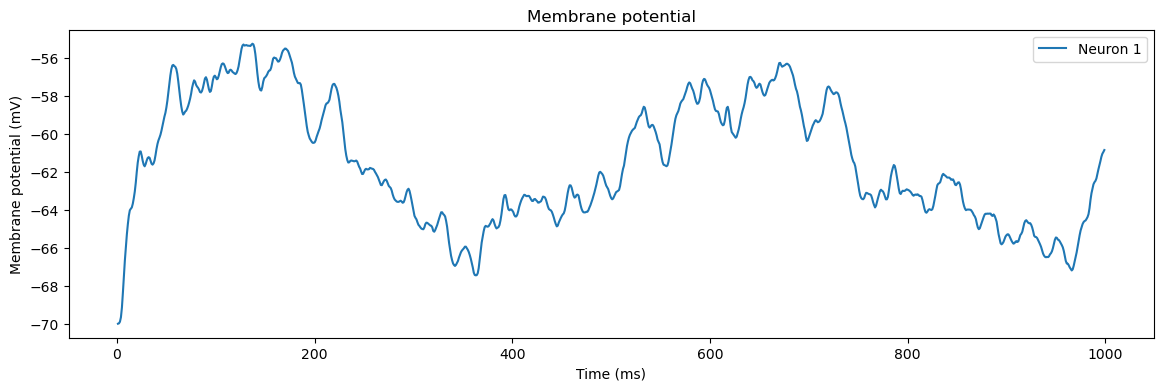

In [20]:
nest.voltage_trace.from_device(voltmeter);

#### Continued simulation

Our network has now been simulated for 1000 ms. By calling `Simulate()` again (without resetting the NEST kernel), the simulation will continue from where we left it. We simulate the network for 4000 ms more:

In [21]:
nest.Simulate(4000.0)


Nov 06 15:10:21 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Nov 06 15:10:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 4000
    Number of OpenMP threads: 1
    Not using MPI

Nov 06 15:10:21 SimulationManager::run [Info]: 
    Simulation finished.


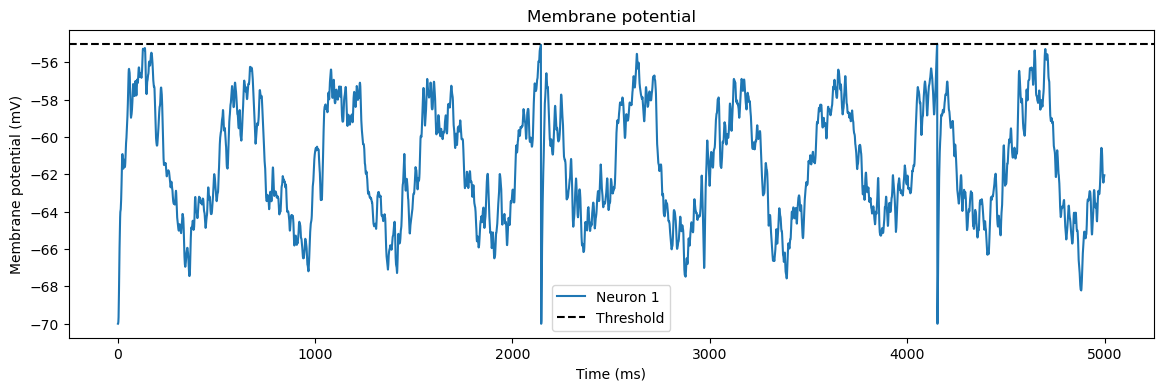

In [22]:
nest.voltage_trace.from_device(voltmeter);
plt.axhline(neuron.V_th, color="k", ls='--', label="Threshold");
plt.legend();

### Using Pandas with NEST

- Pandas is a powerful tool for managing and analysing large amounts of data
- Data returned by NEST can in many cases be easily converted to Pandas dataframes
- To first approximation, Pandas dataframes work like NumPy arrays with named columns

#### Extracting connection data

- We use the same `.get()` call as above
- We obtain a tuple with one dictionary per connection
- We can convert this directly into a dataframe
- If we `print` the data, we get an ASCII-pretty-printed table

In [23]:
conn_data = pd.DataFrame.from_records(conns.get())
conn_data

,delay,port,receptor,sizeof,source,synapse_id,synapse_model,target,target_thread,weight
0,1.0,0,0,32,2,23,static_synapse,1,0,1.0
1,1.0,0,0,32,3,23,static_synapse,1,0,2.0
2,1.0,0,0,32,4,23,static_synapse,1,0,-5.0
3,1.0,0,1,32,5,23,static_synapse,1,0,1.0


- We can even get $\LaTeX$ code

In [24]:
print(conn_data.style.to_latex())

\begin{tabular}{lrrrrrrlrrr}
 & delay & port & receptor & sizeof & source & synapse_id & synapse_model & target & target_thread & weight \\
0 & 1.000000 & 0 & 0 & 32 & 2 & 23 & static_synapse & 1 & 0 & 1.000000 \\
1 & 1.000000 & 0 & 0 & 32 & 3 & 23 & static_synapse & 1 & 0 & 2.000000 \\
2 & 1.000000 & 0 & 0 & 32 & 4 & 23 & static_synapse & 1 & 0 & -5.000000 \\
3 & 1.000000 & 0 & 1 & 32 & 5 & 23 & static_synapse & 1 & 0 & 1.000000 \\
\end{tabular}



- By default, we get all properties of the connections
- We can also explicitly select only certain properties

In [25]:
properties = ('source', 'target', 'delay', 'weight')
conn_data = pd.DataFrame.from_records(conns.get(properties))
conn_data

,delay,source,target,weight
0,1.0,2,1,1.0
1,1.0,3,1,2.0
2,1.0,4,1,-5.0
3,1.0,5,1,1.0


#### Plotting "manually"

- We can also extract data from recording devices into dataframes
- Recorded data is in the `events` property of the voltmeter

In [26]:
voltmeter.get()

{'element_type': 'recorder',
 'events': {'senders': array([1, 1, 1, ..., 1, 1, 1]),
  'times': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.997e+03, 4.998e+03,
         4.999e+03]),
  'V_m': array([-70.        , -69.98003584, -69.89443954, ..., -62.17732795,
         -62.12759102, -62.05174846])},
 'frozen': False,
 'global_id': 5,
 'interval': 1.0,
 'label': '',
 'local': True,
 'model': 'voltmeter',
 'model_id': 88,
 'n_events': 4999,
 'node_uses_wfr': False,
 'offset': 0.0,
 'origin': 0.0,
 'record_from': ('V_m',),
 'record_to': 'memory',
 'start': 0.0,
 'stop': 1.7976931348623157e+308,
 'thread': 0,
 'thread_local_id': 4,
 'time_in_steps': False,
 'vp': 0}

In [27]:
vm_data = pd.DataFrame(voltmeter.get('events'))

vm_data[:5]

,senders,times,V_m
0,1,1.0,-70.000000
1,1,2.0,-69.980036
2,1,3.0,-69.894440
3,1,4.0,-69.655373
4,1,5.0,-69.143218


- We can obtain statistics on the data (here, meaningful for $V_m$ only)

In [28]:
vm_data.describe()

,senders,times,V_m
count,4999.0,4999.000000,4999.000000
mean,1.0,2500.000000,-61.469683
std,0.0,1443.231328,3.016184
min,1.0,1.000000,-70.000000
25%,1.0,1250.500000,-63.983108
50%,1.0,2500.000000,-61.856275
75%,1.0,3749.500000,-58.737964
max,1.0,4999.000000,-55.006970


- We can plot using the `plot()` method of the Pandas DataFrame object ([more on plotting in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html))

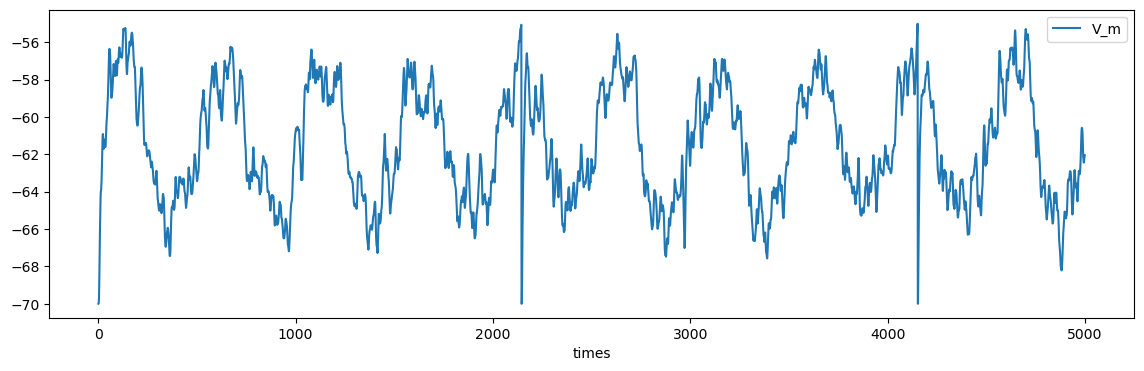

In [29]:
vm_data.plot(x='times', y='V_m');

- We can plot using the normal `plot()` command

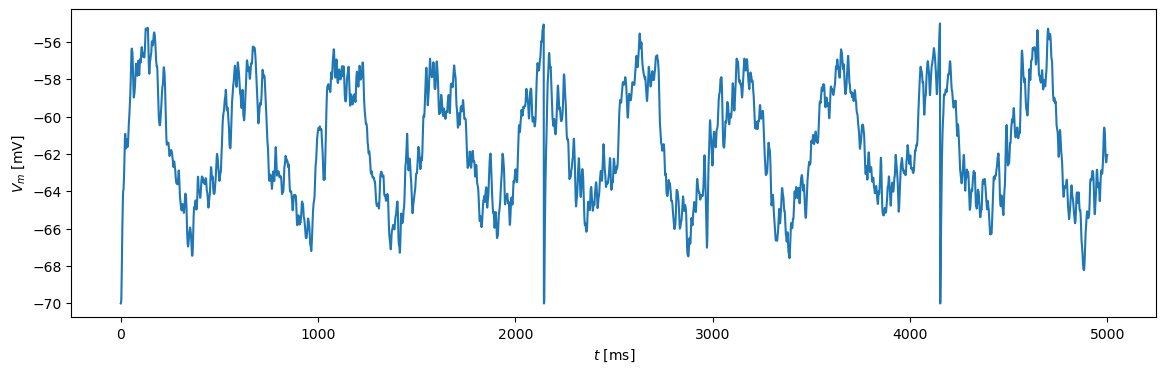

In [30]:
plt.plot(vm_data.times, vm_data.V_m)
plt.xlabel('$t$ [ms]')
plt.ylabel('$V_m$ [mV]');

## The Brunel Network: A sparsely connected network

* $N_E=10\,000$ excitatory neurons
* $N_I=2\,500$ inhibitory neurons
* 10% connectivity
* Scaling parameter allows adjustment of network size for faster testing (changes dynamics)
* N. Brunel, J Comput Neurosci 8:183 (2000)

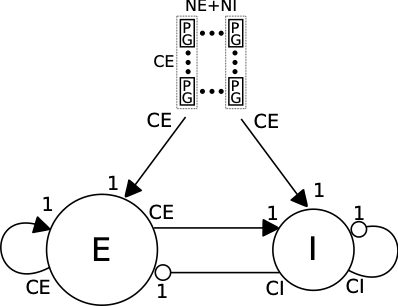

### Define parameters

In [31]:
# Network parameters. These are given in Brunel (2000) J.Comp.Neuro.
g       = 5.0    # ratio of IPSP to EPSP amplitude: J_I/J_E
eta     = 2.0    # rate of external population in multiples of threshold rate
delay   = 1.5    # synaptic delay [ms]
tau_m   = 20.0   # membrane time constant [ms]
V_th    = 20.0   # spike threshold potential [mV]

scale = 1                 # scaling parameter for adjusting network size
N_E = int(scale * 10000)  # number of excitatory neurons
N_I = int(scale *  2500)  # number of inhibitory neurons
N_neurons = N_E + N_I     # total number of neurons

epsilon = 0.1             # connection probability
C_E = int(N_E * epsilon)  # number of excitatory synapses per neuron
C_I = int(N_I * epsilon)  # number of inhibitory synapses per neuron

J_E = 0.1        # peak of EPSP [mV]
J_I = -g * J_E   # peak of IPSP [mV]

nu_ex  = eta * V_th / (J_E * C_E * tau_m)  # rate of an external neuron [mHz]
p_rate = 1000.0 * nu_ex * C_E              # rate of the external population [Hz]

### Configure kernel and neuron defaults

In [32]:
nest.ResetKernel()
nest.total_num_virtual_procs = 4

In [33]:
nest.SetDefaults(
    "iaf_psc_delta",
    {
        "C_m": 1.0,       # membrance capacitance [pF]
        "tau_m": tau_m,
        "t_ref": 2.0,     # refactory period [ms]
        "E_L": 0.0,       # resting membrane potential [mV]
        "V_th": V_th,
        "V_reset": 10.0   # reset potential [mV]
    }
)

### Create neurons

In [34]:
nodes_E = nest.Create("iaf_psc_delta", N_E)
nodes_I = nest.Create("iaf_psc_delta", N_I)
nodes = nodes_E + nodes_I

### Connect neurons with each other

In [35]:
excitatory = {"synapse_model": "static_synapse", "weight": J_E, "delay": delay}
inhibitory = {"synapse_model": "static_synapse", "weight": J_I, "delay": delay}

nest.Connect(
    nodes_E,
    nodes,
    conn_spec={"rule": "fixed_indegree", "indegree": C_E},
    syn_spec=excitatory
)

nest.Connect(
    nodes_I,
    nodes,
    conn_spec={"rule": "fixed_indegree", "indegree": C_I},
    syn_spec=inhibitory
)

### Add stimulation and recording devices

In [36]:
noise = nest.Create("poisson_generator", params={"rate": p_rate})

# connect using all_to_all: one noise generator to all neurons
nest.Connect(noise, nodes, syn_spec=excitatory)

spikes_E = nest.Create("spike_recorder", params={"label": "Exc"})
spikes_I = nest.Create("spike_recorder", params={"label": "Inh"})

N_rec = 100   # Number of neurons to record from

# connect excitatory and inhibitory spike recorders to a subset
# of the corresponding neuron population using all_to_all
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

### Simulate

The simulation progress is shown in the terminal window in which you started `ipython notebook`.

In [37]:
simtime = 1000
nest.Simulate(simtime)


Nov 06 15:10:23 NodeManager::prepare_nodes [Info]: 
    Preparing 12512 nodes for simulation.

Nov 06 15:10:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12512
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Not using MPI

Nov 06 15:10:29 SimulationManager::run [Info]: 
    Simulation finished.


### Extract recorded data and display

#### Computing spike rates

In [38]:
rate_ex= spikes_E.n_events / simtime * 1000 / N_rec
print(f"Excitatory rate: {rate_ex:.2f} [1/s]")

rate_in= spikes_I.n_events / simtime * 1000 / N_rec
print(f"Inhibitory rate: {rate_in:.2f} [1/s]")

Excitatory rate: 36.53 [1/s]
Inhibitory rate: 36.94 [1/s]


#### Visualization with raster_plot

In [39]:
nest.raster_plot.from_device?

Signature: nest.raster_plot.from_device(detec, **kwargs)
Docstring:
Plot raster from a spike recorder.

Parameters
----------
detec : TYPE
    Description
kwargs:
    Parameters passed to _make_plot

Raises
------
nest.kernel.NESTError
File:      ~/github/nest_dev/nest/bld_3_6/install/lib/python3.11/site-packages/nest/raster_plot.py
Type:      function

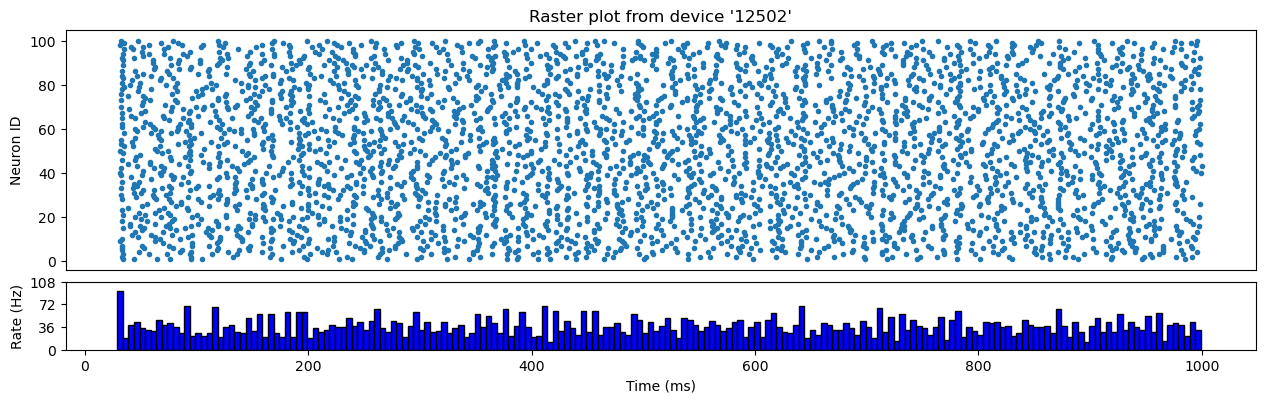

In [40]:
nest.raster_plot.from_device(spikes_E, hist=True);

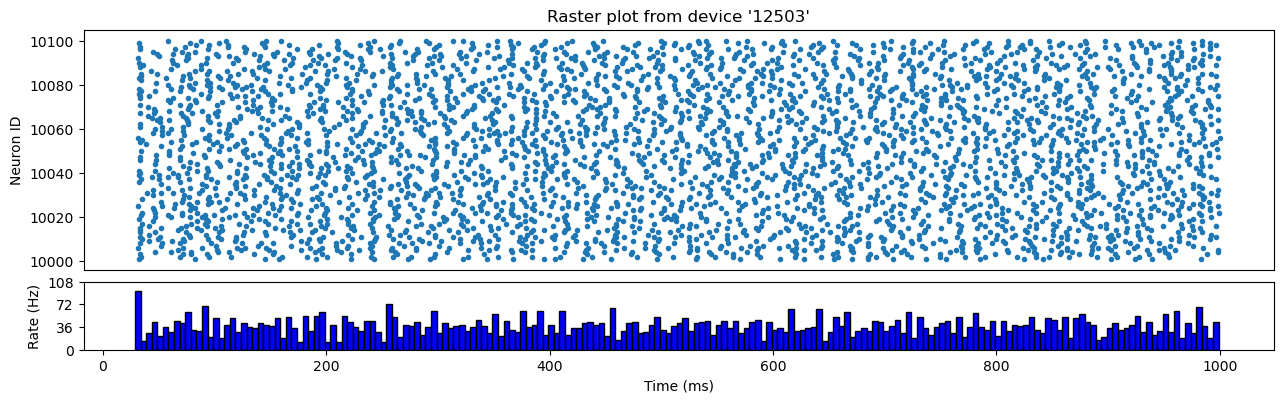

In [41]:
nest.raster_plot.from_device(spikes_I, hist=True);

#### Managing data with Pandas and plotting "manually"

In [42]:
sdE_data = pd.DataFrame(spikes_E.get('events'))
sdI_data = pd.DataFrame(spikes_I.get('events'))

In [43]:
sdE_data[:10].T

,0,1,2,3,4,5,6,7,8,9
senders,40.0,76.0,100.0,28.0,36.0,84.0,92.0,96.0,52.0,44.0
times,31.8,32.4,32.5,33.4,33.3,33.5,33.4,34.9,35.2,38.8


In [44]:
sdE_data.describe().T

,count,mean,std,min,25%,50%,75%,max
senders,3653.0,50.181495,28.713081,1.0,26.0,50.0,75.0,100.0
times,3653.0,511.325842,280.236895,31.6,267.6,508.1,751.4,1000.0


##### Raster plot of spikes

- We plot sender GIDs vs spike times
- We only plot the first 50 excitatory neurons

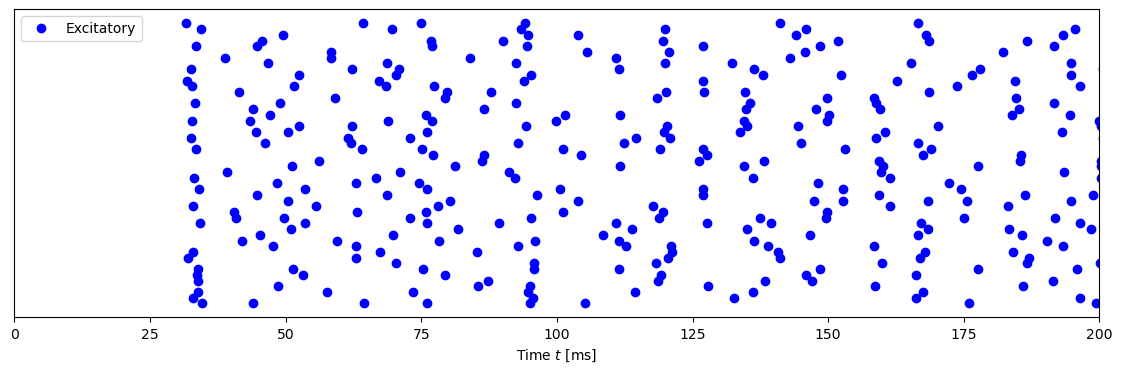

In [45]:
e_spikes_plot = sdE_data[sdE_data.senders <= 50]

plt.plot(e_spikes_plot.times, e_spikes_plot.senders, 
         'bo', label='Excitatory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.yticks([])
plt.xlim(0, 200);

##### Spike-time histogram

- Explicit bins give us better control over binning
- We could also use NumPy's histogram function
- Histogram type `step` usually gives cleaner diagrams when we have many bins

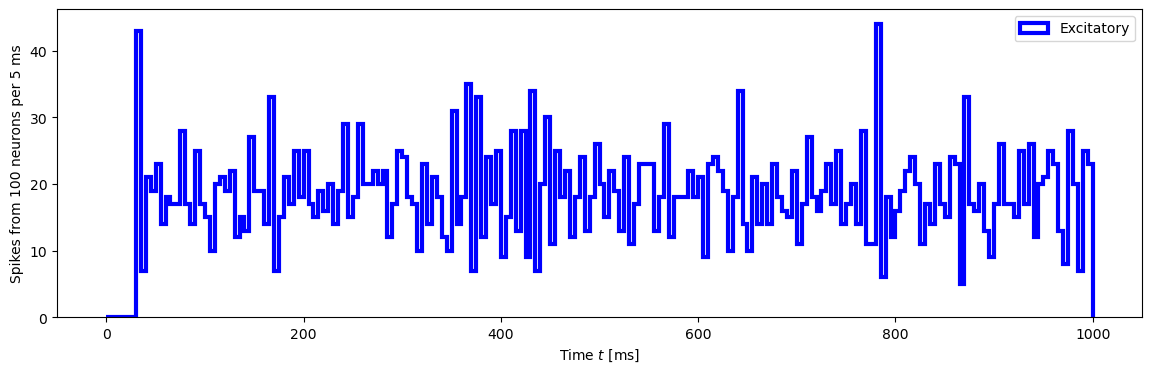

In [46]:
bins = np.arange(0., 1001., 5.)
plt.hist(sdE_data.times, bins=bins, histtype='step', lw=3, color='b', 
         label='Excitatory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Spikes from 100 neurons per 5 ms');

## Randomizing Neurons and Synapses

### Parallelism in NEST

- NEST can combine MPI-based and thread-based parallelism
- The key concept in parallel NEST is the *virtual process* (VP)
    - For $N_M$ MPI processes with $N_T$ threads each, be have $$N_{VP}=N_M\times N_T$$ virtual processes
    - For fixed $N_{VP}$, a NEST simulation shall yield identical results, independent of how the virtual processes are divided into MPI processes and threads
    - Recording devices write one file per MPI process, data from those files have to be pooled
- In this notebook, we only use thread-based parallelism: $N_{VP}=N_T$, $N_M=1$

### Random numbers in NEST

NEST 3 manages random numbers internally for serial and parallel simulations. This is one of the major advantages over NEST 2. You can easily change the random number generator used and set the random seed:

In [47]:
nest.rng_types

('Philox_32',
 'Philox_64',
 'Threefry_32',
 'Threefry_64',
 'mt19937',
 'mt19937_64')

In [48]:
nest.set(rng_type='Threefry_32', rng_seed=1234567)

In [49]:
nest.rng_type = 'Threefry_32'
nest.rng_seed = 26

### Creating neurons with randomized membrane potential

- We want to randomize the initial $V_m$ uniformly over $[V_{\textrm{min}}, V_{\textrm{max}})$ 
- First, we set the random number generator type and seed and the number of virtual processes
- We also set model defaults for our neuron model

In [50]:
nest.ResetKernel()
nest.set(rng_type='Threefry_32', 
         rng_seed=1234567,
         total_num_virtual_procs=4)
nest.SetDefaults("iaf_psc_delta", 
                 {"C_m": 1.0, "tau_m": tau_m, "t_ref": 2.0, "E_L": 0.0,
                  "V_th": V_th, "V_reset": 10.0})

- We now create the neurons, specificying the desired $V_m$ distribution

In [51]:
nodes_E = nest.Create("iaf_psc_delta", N_E, params={'V_m': nest.random.uniform(-V_th, V_th)})
nodes_I = nest.Create("iaf_psc_delta", N_I, params={'V_m': nest.random.uniform(-V_th, V_th)})
nodes = nodes_E + nodes_I

#### Connecting with randomized weights

- We exploit that `Connect()` can draw random weights
- We only randomize outgoing connections from the excitatory neurons

In [52]:
excitatory_random = {"synapse_model": "static_synapse", "delay": delay,
                     "weight": nest.random.uniform(0.5*J_E, 1.5*J_E)}

nest.Connect(nodes_E, nodes,
             conn_spec={"rule": "fixed_indegree", "indegree": C_E},
             syn_spec=excitatory_random)

nest.Connect(nodes_I, nodes,
             conn_spec={"rule": "fixed_indegree", "indegree": C_I},
             syn_spec=inhibitory)

#### Adding stimulation and recording devices

- Same as before

In [53]:
noise = nest.Create("poisson_generator", params={"rate": p_rate})

# connect using all_to_all: one noise generator to all neurons
nest.Connect(noise, nodes, syn_spec=excitatory)

spikes_E = nest.Create("spike_recorder", params={"label": "Exc"})
spikes_I = nest.Create("spike_recorder", params={"label": "Inh"})

N_rec   = 100   # Number of neurons to record from

# connect using all_to_all: all recorded excitatory neurons to one detector
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

### Inspecting the Network

#### Initial membrane potentials

- Read out $V_m$ from all neurons
- Plot as scatter plot and histogram

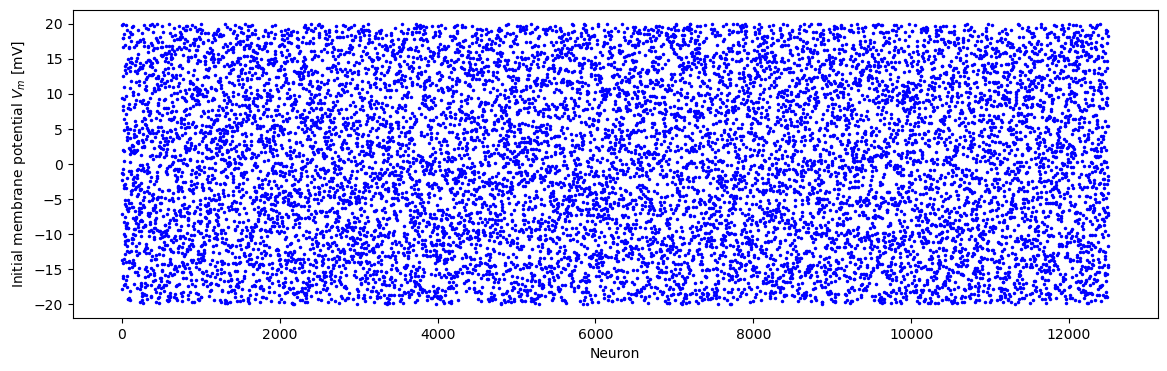

In [54]:
plt.plot(nodes.V_m, 'b.', markersize=3)
plt.xlabel('Neuron')
plt.ylabel('Initial membrane potential $V_m$ [mV]');

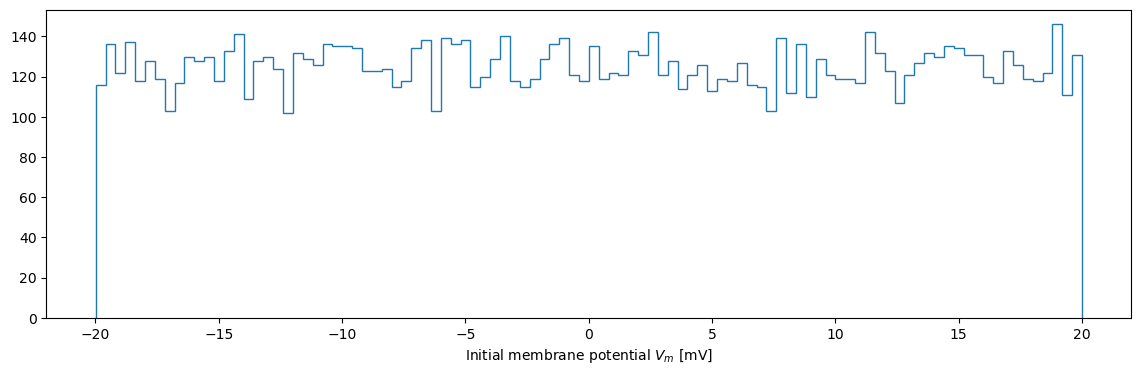

In [55]:
plt.hist(nodes.V_m, bins=100, histtype='step')
plt.xlabel('Initial membrane potential $V_m$ [mV]');

#### Synaptic weights

- We collect data on all outgoing synapses from the first 100 neurons
- We need to specify `target=nodes` to avoid "picking up" connections to the spike recorder
- We store as Pandas data frame

In [56]:
exc_conns = nest.GetConnections(source=nodes_E[:100], target=nodes)
exc_weights = pd.DataFrame({'weight': exc_conns.get('weight')})

exc_weights.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,125019.0,0.100028,0.028815,0.05,0.075252,0.100097,0.124968,0.149999


- We scatter plot the first 1000
- We create a histogram of all

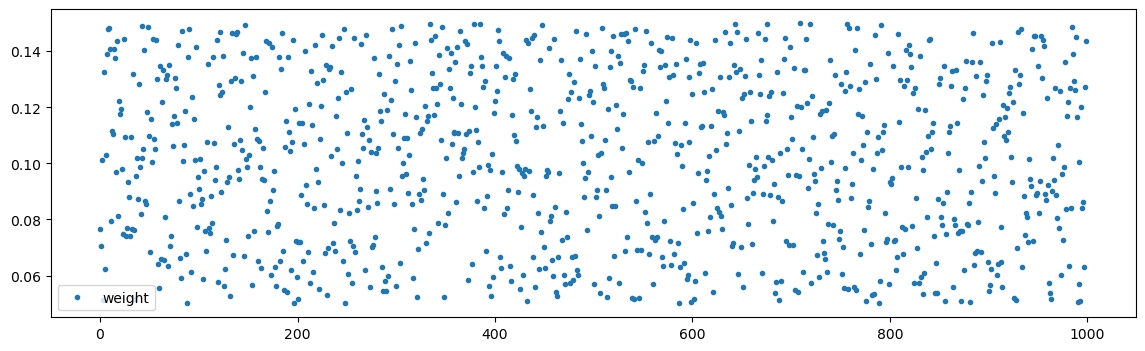

In [57]:
exc_weights[:1000].plot(style='.');

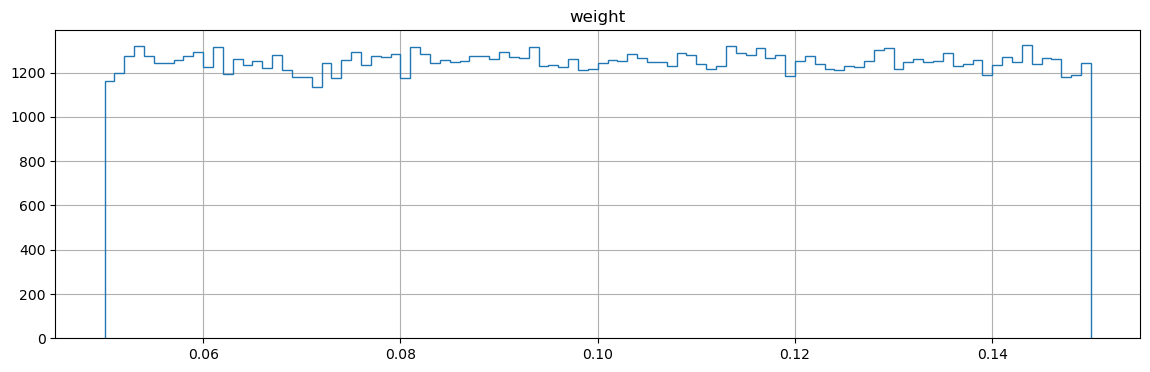

In [58]:
exc_weights.hist(bins=100, histtype='step');

### Simulating the network

In [59]:
nest.Simulate(1000)


Nov 06 15:10:33 NodeManager::prepare_nodes [Info]: 
    Preparing 12512 nodes for simulation.

Nov 06 15:10:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12512
    Simulation time (ms): 1000
    Number of OpenMP threads: 4
    Not using MPI

Nov 06 15:10:41 SimulationManager::run [Info]: 
    Simulation finished.


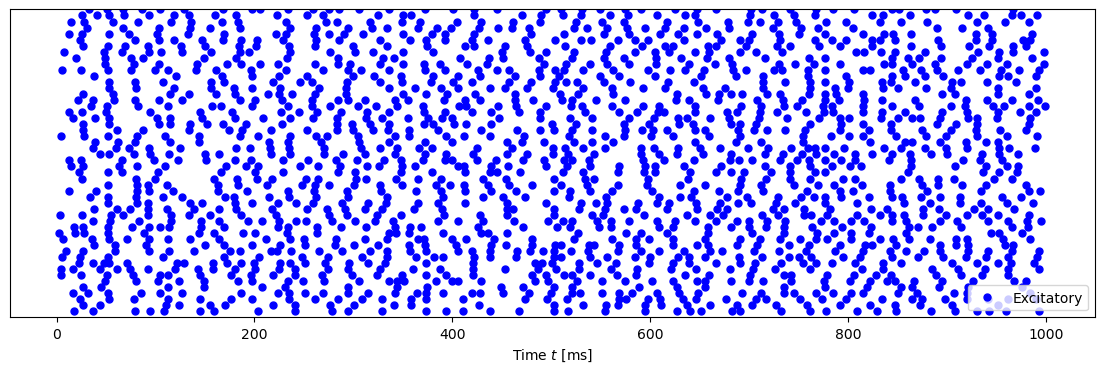

In [60]:
sdE_data = pd.DataFrame(spikes_E.get('events'))
sdI_data = pd.DataFrame(spikes_I.get('events'))

e_spikes_plot = sdE_data[sdE_data.senders <= 100]
plt.plot(e_spikes_plot.times, e_spikes_plot.senders, 'bo', 
         markersize=5, label='Excitatory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.yticks([])
plt.ylim(0, 51);

#### Spike histogram

The historgram shows a smoother onset of activity due to the randomization of initial membrane potentials.

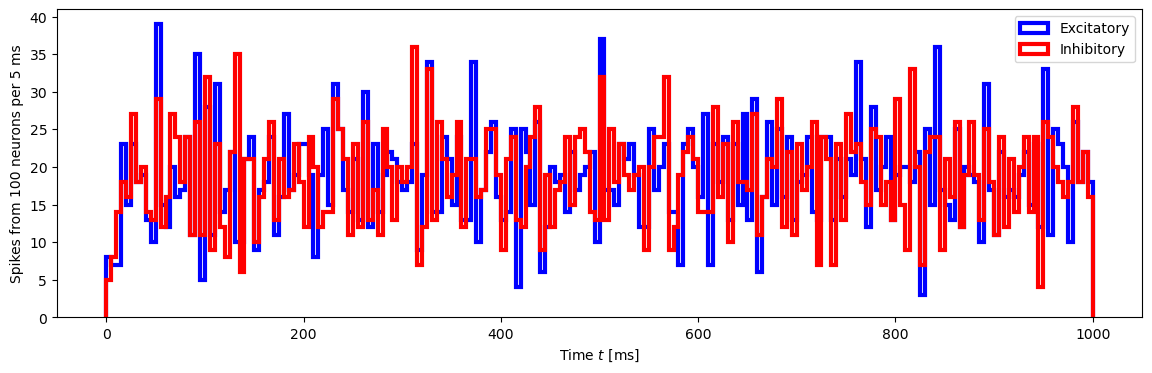

In [61]:
bins = np.arange(0., 1001., 5.)
plt.hist(sdE_data.times, bins=bins, histtype='step', lw=3, color='b', 
         label='Excitatory')
plt.hist(sdI_data.times, bins=bins, histtype='step', lw=3, color='r', 
         label='Inhibitory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Spikes from 100 neurons per 5 ms');